In [1]:
# ================================================
# 必要なライブラリのインポート
# ================================================

# --------------------------------
# 数値計算・データ処理
# --------------------------------
import numpy as np  # 数値計算ライブラリ（ベクトル・行列演算など）
import pandas as pd  # データフレーム操作（時系列の取り扱いに必須）

# --------------------------------
# 可視化ライブラリ
# --------------------------------
from matplotlib import pyplot as plt  # グラフ描画の基本ライブラリ
import matplotlib.dates as mdates  # 時系列軸のフォーマット設定に便利
import seaborn as sns  # 統計的な可視化スタイル（美しい出力）

sns.set()  # Seabornのデフォルトスタイルを有効化（見やすいグラフに）

# --------------------------------
# 統計モデリング・時系列分析
# --------------------------------
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as tsa  # 時系列専用ツール（自己相関, ARIMAなど）

# --------------------------------
# sktime：時系列処理の基本モジュール
# --------------------------------
from sktime.utils.plotting import plot_series  # 時系列データの簡単な可視化
from sktime.forecasting.base import ForecastingHorizon  # 予測対象期間の指定

# --------------------------------
# sktime：指数平滑法・ETSモデル（トレンド・季節性モデル）
# --------------------------------
from sktime.forecasting.exp_smoothing import ExponentialSmoothing  # Holt-Wintersモデル
from sktime.forecasting.ets import AutoETS  # 自動ETSモデル選択

# --------------------------------
# sktime：予測性能評価（誤差指標）
# --------------------------------
from sktime.performance_metrics.forecasting import (
    mean_absolute_scaled_error,  # MASE（基準モデルとの誤差比）
    MeanAbsoluteError,  # MAE（平均絶対誤差）
    mean_absolute_percentage_error,  # MAPE（平均絶対パーセント誤差）
    mean_absolute_error,  # MAE（関数形式）
)

# --------------------------------
# sktime：予測モデルの検証（クロスバリデーション等）
# --------------------------------
from sktime.forecasting.model_selection import (
    temporal_train_test_split,  # 時系列に基づく訓練・テスト分割
    ExpandingWindowSplitter,  # 時間窓を拡張しながらCVを実行
    ForecastingGridSearchCV,  # グリッドサーチによるハイパーパラメータ最適化
)
from sktime.forecasting.model_evaluation import evaluate  # CVの自動評価関数

# --------------------------------
# sktime：データ変換（前処理）
# --------------------------------
from sktime.transformations.series.boxcox import LogTransformer  # 対数変換など

# --------------------------------
# sktime：パイプライン・アンサンブル
# --------------------------------
from sktime.forecasting.compose import (
    TransformedTargetForecaster,  # 前処理＋予測モデルを一体化
    MultiplexForecaster,  # モデルの切替・比較
    EnsembleForecaster,  # モデルを統合して予測（単純平均など）
    AutoEnsembleForecaster,  # 自動アンサンブル（性能ベース加重など）
)
from sktime.transformations.compose import OptionalPassthrough  # 前処理を有無切替できる

# ================================================
# ✅ このブロックでできること
# - Holt-WintersやETSによる時系列予測
# - グリッドサーチ＋クロスバリデーション評価
# - 前処理を含むパイプライン設計
# - モデルアンサンブル・自動モデル選択
# ================================================

In [2]:
# 表示設定
np.set_printoptions(linewidth=60)
pd.set_option("display.width", 80)

from matplotlib.pylab import rcParams

rcParams["figure.figsize"] = 8, 4

In [3]:
# 飛行機乗客数データの読み込み
air_passengers = sm.datasets.get_rdataset("AirPassengers").data

# 日付インデックスの作成(PeriodIndex)
date_index = pd.period_range(start="1949-01", periods=len(air_passengers), freq="M")
air_passengers.index = date_index

# 不要な時間ラベルの削除
air_passengers = air_passengers.drop(air_passengers.columns[0], axis=1)

In [4]:
# データの分割
train, test = temporal_train_test_split(air_passengers, test_size=36)

# 予測期間
fh = np.arange(1, len(test) + 1)

In [5]:
data = pd.Series([1, 2, 3])
data

0    1
1    2
2    3
dtype: int64

In [ ]:
# ================================================
# 単純指数平滑法（Simple Exponential Smoothing）の準備
# ================================================

# 平滑化定数（α）
# 0 < α ≤ 1 の範囲で設定。
# αが大きいほど「新しいデータを重視」し、αが小さいほど「過去データを重視」する。
alpha = 0.8

# データの長さ分、(1 - α) を並べたリストを作成
# （指数平滑での過去データの重みを計算するために使用）
alpha_list = np.tile(1 - alpha, len(data))

# 結果の確認（例：0.2が3個並ぶなど）
alpha_list

array([0.2, 0.2, 0.2])

In [7]:
# --------------------------------
# 核心部分：重みの算出
# --------------------------------
#   α_list ** np.arange(0, len(data)) * α
#
# 具体的な意味：
#   np.arange(0, len(data)) → [0, 1, 2, 3, ...]
#   α_list ** np.arange(...) → [(1-α)^0, (1-α)^1, (1-α)^2, ...]
#   それに α を掛けることで：
#       [α*(1-α)^0, α*(1-α)^1, α*(1-α)^2, ...]
#   という指数的に減衰する重みが得られる。
#
# 例：α=0.8 の場合
#   → [0.8, 0.16, 0.032, 0.0064, ...] のように
#      最新ほど大きく、古いほど小さい重みになる。
weight = alpha_list ** np.arange(0, len(data)) * alpha

# 結果を確認
weight

array([0.8  , 0.16 , 0.032])

In [8]:
# ================================================
# 指数平滑法による予測値の計算
# ================================================

# 重みを逆順にする
# （理由）計算時に「古いデータ × 小さい重み」「新しいデータ × 大きい重み」
# が対応するように、重みの順序を入れ替える。
# これで最新の観測値ほど大きな重みが掛かるようになる。
weight = weight[::-1]

# --------------------------------
# 指数平滑化法による予測値の算出
# --------------------------------
# 予測値は、各データとその重みの積の総和で表される：
#
#   ŷ_t = Σ [ α * (1 - α)^(t - i) * y_i ]
#
# このコードでは「data * weight」で要素ごとの積をとり、
# np.sum() でそれを合計している。
#
# 例：
#   data = [y1, y2, y3, y4]
#   weight = [0.0064, 0.032, 0.16, 0.8]（α=0.8の場合）
#   → ŷ_4 = y1*0.0064 + y2*0.032 + y3*0.16 + y4*0.8
#
# したがって、新しい観測値ほど強く反映される。
print(f"4時点目の予測値 {np.sum(data * weight):.4g} ")

4時点目の予測値 2.752 


In [9]:
# データの並び順の変更
data_2 = pd.Series([3, 2, 1])

# 指数平滑化法による予測値
print(f"4時点目の予測値 {np.sum(data_2 * weight):.4g} ")

4時点目の予測値 1.216 


In [10]:
# 参考：単なるデータの平均
np.mean(data)

2.0

In [11]:
# ================================================
# 指数平滑法（単純指数平滑）の逐次計算
# ================================================

# 初期値（t=1 の平滑値）
# ------------------------------------------------
# 最初の平滑値 ŷ₁（ハット）は「予測の出発点」。
# 通常は観測値の初期値や0などを仮定する。
yhat1 = 0

# --------------------------------
# 各時点の予測値の更新式
# --------------------------------
# 一般式：
#     ŷ_t = α * y_{t-1} + (1 - α) * ŷ_{t-1}
#
# α（アルファ）は平滑化定数で、
#   ・α が大きい → 直近の観測値を重視（変化に敏感）
#   ・α が小さい → 過去の予測値を重視（変化に鈍感）

# 各時点での計算過程：
yhat2 = alpha * data[0] + (1 - alpha) * yhat1  # 2時点目の平滑値
yhat3 = alpha * data[1] + (1 - alpha) * yhat2  # 3時点目の平滑値
yhat4 = alpha * data[2] + (1 - alpha) * yhat3  # 4時点目の平滑値

# --------------------------------
# 結果の確認
# --------------------------------
# 各時点での予測値を表示する。
# 小数点4桁で整形して出力。
print(f"2時点目 {yhat2:.4g} | 3時点目 {yhat3:.4g} | 4時点目 {yhat4:.4g}")

# 💡 ポイント
# ・指数平滑法は再帰的に計算されるため、
#   逐次的に ŷ_t を更新していく構造を持つ。
# ・最新データが入るたびに予測値が滑らかに更新される。

2時点目 0.8 | 3時点目 1.76 | 4時点目 2.752


In [12]:
# 初期値
yhat1 = data[0]

# 予測値の計算
yhat2 = alpha * data[0] + (1 - alpha) * yhat1
yhat3 = alpha * data[1] + (1 - alpha) * yhat2
yhat4 = alpha * data[2] + (1 - alpha) * yhat3

# 結果の確認
print(f"2時点目 {yhat2:.4g} | 3時点目 {yhat3:.4g} | 4時点目 {yhat4:.4g}")

2時点目 1 | 3時点目 1.8 | 4時点目 2.76


In [13]:
# ================================================
# 単純指数平滑化法（Exponential Weighted Moving Average, EWMA）
# ================================================

# ewm(alpha=0.8, adjust=False)
# --------------------------------
# pandas.Series.ewm() は「指数加重移動平均」を計算するためのメソッドである。
# alpha（α）は平滑化定数を表す。
#   ・αが大きいほど、直近の観測値を重視（変化に敏感）
#   ・αが小さいほど、過去の値を重視（滑らかに変化）
#
# adjust=False の場合：
#   「再帰式による指数平滑法」と同じ計算を行う。
#   つまり、以下の式に従って逐次更新される：
#       ŷ_t = α * y_t + (1 - α) * ŷ_{t-1}

# adjust=True（デフォルト）の場合：
#   過去全体の重みを正規化して計算するため、
#   純粋な再帰形の指数平滑とは異なる（学術書での定義と異なる場合がある）。

# --------------------------------
# ewm() オブジェクトを生成
ewma_pd = data.ewm(alpha=0.8, adjust=False)

# --------------------------------
# mean() によって実際に平滑化を実行
# 各時点 t において、過去の観測値に指数的な重みを付けて平均を計算する。
ewma_pd.mean()

# 💡 計算イメージ
# t=1 から順に以下の再帰式で更新される：
#     ŷ₁ = y₁
#     ŷ_t = α * y_t + (1 - α) * ŷ_{t-1}   （t ≥ 2）
#
# これにより、最新の観測値に最も大きな重みが与えられ、
# 過去に遡るほど重みが指数的に減少していく。

0    1.00
1    1.80
2    2.76
dtype: float64

In [14]:
# ================================================
# 単純指数平滑法（Simple Exponential Smoothing）
# ================================================
# statsmodels.tsa.holtwinters.SimpleExpSmoothing は
# 「単純指数平滑法（Simple Exponential Smoothing）」を実装するクラスである。
#
# 基本式：
#   ŷ_t = α * y_t + (1 - α) * ŷ_{t-1}
#   （α：平滑化定数, 0 < α ≤ 1）
#
# 目的：
#   最新の観測値を重視しつつ、過去の観測値を指数的に減衰させて平均化する。
#   トレンドや季節性を持たない系列（定常系列）に有効。

# --------------------------------
# モデルの構築
# --------------------------------
ewma_sm = tsa.SimpleExpSmoothing(
    data,
    initialization_method="known",  # 初期化方法を指定
    initial_level=0,  # 初期値（ŷ₁）を明示的に 0 に設定
).fit(
    smoothing_level=0.8,  # 平滑化定数 α = 0.8
    optimized=False,  # α を自動最適化せず、手動で指定
)

# --------------------------------
# 当てはめ値（fittedvalues）の取得
# --------------------------------
# 各時点 t における指数平滑予測値 ŷ_t が格納されている。
# 再帰式：
#     ŷ₁ = 0  （初期値）
#     ŷ_t = 0.8 * y_t + 0.2 * ŷ_{t-1}
# として逐次的に更新されていく。
ewma_sm.fittedvalues

# 💡メモ：
#   initialization_method='known' により、初期レベルを明示的に指定可能。
#   これを 'heuristic' や 'estimated' にすると、自動的に初期値を推定してくれる。

0    0.00
1    0.80
2    1.76
dtype: float64

In [15]:
# ================================================
# 1期先の予測（forecast）
# ================================================
# SimpleExpSmoothing.fit() で得られたモデル ewma_sm を使って、
# 次の時点（t+1）の予測値を計算する。
#
# 単純指数平滑法における1期先予測の理論式：
#   ŷ_{t+1} = ŷ_t
#
# → すなわち、次の時点の予測値は「最新の平滑値」と等しい。
#   （未来に関する追加情報がないため、一定値を保つ形になる）

ewma_sm.forecast(1)

# 出力例：
# 4    2.4138
# dtype: float64
#
# ※これは「4時点目の予測値」を意味する。
#   3時点目までのデータをもとに、指数的に重み付けして求められた
#   最新の平滑値が次の期（t+1）の予測値となる。

3    2.752
dtype: float64

In [16]:
# ================================================
# 初期値を「初期データ（最初の観測値）」に設定した場合の指数平滑法
# ================================================

# initialization_method='legacy-heuristic' を指定すると、
# 初期平滑値（level_0）を「最初の観測値 y₁」として設定する。
# これは古典的な指数平滑法の実装方法であり、
# 多くの教科書で紹介される手法に対応する。

ewma_sm_lh = tsa.SimpleExpSmoothing(
    data, initialization_method="legacy-heuristic"  # 初期値 = 最初のデータ点
).fit(
    smoothing_level=0.8, optimized=False
)  # 平滑化定数 α=0.8 を手動指定

# 当てはめ値（fittedvalues）を確認
# ----------------------------------------
# 各時点における指数平滑化後の値（予測値）を出力する。
# この値は以下の漸化式で計算される：
#
#   ŷ_t = α·y_{t-1} + (1−α)·ŷ_{t−1}
#
# ただし、初期値として：
#   ŷ₁ = y₁
#
# つまり、最初の観測値が初期状態となるため、
# 初期値0のときよりも系列にスムーズに追従する結果となる。

ewma_sm_lh.fittedvalues

0    1.0
1    1.0
2    1.8
dtype: float64

In [17]:
# ================================================
# 1期先予測（単純指数平滑法）
# ================================================

# forecast(1) は、次の1時点先（t+1）の予測値を返す。
# 単純指数平滑法における1期先予測は以下の式で表される：
#
#   ŷ_{t+1} = ŷ_t
#
# つまり、「次の予測値」は「直前の平滑値」と等しい。
# これは、指数平滑法が“将来の変動を考慮しない”モデル
# （＝ランダムウォーク型の平滑予測）であることを意味する。

ewma_sm_lh.forecast(1)

3    2.76
dtype: float64

In [18]:
# ================================================
# 単純指数平滑法：初期値と平滑化定数の最適推定
# ================================================

# initialization_method='estimated' に設定することで、
# モデルが自動的に「初期値 (level_0)」と「平滑化定数 α（alpha）」を推定する。
# このとき、損失関数（通常は二乗誤差：Σ(y_t - ŷ_t)^2）を最小化するように
# パラメータが最適化される。

ewma_best = tsa.SimpleExpSmoothing(data, initialization_method="estimated").fit()

# ------------------------------------------------
# fittedvalues：訓練データ期間における当てはめ値
# ------------------------------------------------
# 各時点での予測値 ŷ_t を表す。
# これらは実測値 y_t に対して指数加重平均によって平滑化された値。

ewma_best.fittedvalues

0    1.0
1    1.0
2    2.0
dtype: float64

In [19]:
# ================================================
# 1期先予測（最適パラメータによる指数平滑法）
# ================================================

# forecast(1) は、「次の1時点先（t+1）」の予測値を返す。
# 単純指数平滑法では次の式で表される：
#
#   ŷ_{t+1} = α * y_t + (1 - α) * ŷ_t
#
# ただし、モデルが最適に推定した平滑化定数 α（alpha）と
# 初期値（level_0）を用いて算出される。
#
# 👉 この予測値は「直前の平滑値」と同じであり、
#    将来の予測は一定（＝水平な予測線）となるのが特徴。

ewma_best.forecast(1)

3    3.0
dtype: float64

In [20]:
# ================================================
# 推定されたパラメータの確認
# ================================================

# SimpleExpSmoothing.fit() の結果オブジェクトでは、
# 推定されたパラメータが `params` 属性に格納されている。
#
# 主な内容は以下の通り：
# --------------------------------
# smoothing_level : α（平滑化定数）
#   → 新しい観測値をどの程度重視するかを表すパラメータ。
#     値が1に近いほど最新のデータを強く反映する。
#
# initial_level   : 初期値（level_0）
#   → 平滑化を始める際の最初の予測値。
#     通常はデータの先頭値か、最適化によって推定される。
#
# SSE             : 残差平方和（誤差の合計）
#   → モデル当てはめ時の誤差の総量を表す。
# --------------------------------

ewma_best.params

{'smoothing_level': 0.9999999850988374,
 'smoothing_trend': nan,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 1.0000000088092982,
 'initial_trend': nan,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [21]:
# ================================================
# 二重指数平滑法（Holtの線形法）の手計算による実装例
# ================================================

# このモデルは「トレンド（傾き）」も考慮するため、
# 単純指数平滑法を拡張した形となる。
#
# 【基本式】
# -----------------------------------------------
#  レベル（平滑化された水準）:
#      l_t = α * y_t + (1 - α) * (l_{t-1} + d_{t-1})
#
#  トレンド（傾き）:
#      d_t = β * (l_t - l_{t-1}) + (1 - β) * d_{t-1}
#
#  予測値（1期先予測）:
#      ŷ_{t+1} = l_t + d_t
# -----------------------------------------------
#
# α : 水準の平滑化定数（最近の観測値をどの程度重視するか）
# β : トレンドの平滑化定数（最近の傾きをどの程度重視するか）
#
# ※ 初期値 (l0, d0) はしばしばデータの最初の観測値とその変化率で近似する。

# 平滑化定数
alpha = 0.8
beta = 0.5

# 初期値
l0 = 0  # 初期レベル
d0 = 0  # 初期トレンド
yhat1 = l0 + d0  # 初期予測値（1時点目の予測）

# ---- 以下、逐次更新 ----
# t = 1
l1 = alpha * data[0] + (1 - alpha) * (l0 + d0)
d1 = beta * (l1 - l0) + (1 - beta) * d0
yhat2 = l1 + d1  # 2時点目の予測値

# t = 2
l2 = alpha * data[1] + (1 - alpha) * (l1 + d1)
d2 = beta * (l2 - l1) + (1 - beta) * d1
yhat3 = l2 + d2  # 3時点目の予測値

# t = 3
l3 = alpha * data[2] + (1 - alpha) * (l2 + d2)
d3 = beta * (l3 - l2) + (1 - beta) * d2
yhat4 = l3 + d3  # 4時点目の予測値

# 結果の確認
print(f"yhat ：2時点目 {yhat2:.4g} | 3時点目 {yhat3:.4g} | 4時点目 {yhat4:.4g}")
print(f"level：1時点目 {l1:.3g} | 2時点目 {l2:.3g} | 3時点目 {l3:.4g}")
print(f"trend：1時点目 {d1:.3g} | 2時点目 {d2:.3g} | 3時点目 {d3:.4g}")

yhat ：2時点目 1.2 | 3時点目 2.56 | 4時点目 3.808
level：1時点目 0.8 | 2時点目 1.84 | 3時点目 2.912
trend：1時点目 0.4 | 2時点目 0.72 | 3時点目 0.896


In [22]:
# ================================================
# Holt法（二重指数平滑法）の実装（パラメータ固定）
# ================================================

# Holt法は単純指数平滑法を拡張し、
# 「水準（level）」と「トレンド（trend）」の両方を推定して
# 将来の変化傾向を考慮した予測を行う。

# 【モデル概要】
# -----------------------------------------------
# レベルの更新式：
#     l_t = α * y_t + (1 - α) * (l_{t-1} + d_{t-1})
#
# トレンドの更新式：
#     d_t = β * (l_t - l_{t-1}) + (1 - β) * d_{t-1}
#
# 予測値：
#     ŷ_{t+h} = l_t + h * d_t
# -----------------------------------------------
# α：水準の平滑化定数（最近のデータへの重み）
# β：トレンドの平滑化定数（最近の傾きへの重み）
#
# initialization_method='known' を指定しているため、
# 初期レベルと初期トレンドを手動で与える。

holt = tsa.Holt(
    data,
    initialization_method="known",  # 初期値を手動で設定する
    initial_level=0,  # 初期レベル l₀ = 0
    initial_trend=0,  # 初期トレンド d₀ = 0
).fit(
    smoothing_level=0.8,  # 水準の平滑化定数 α = 0.8
    smoothing_trend=0.5,  # トレンドの平滑化定数 β = 0.5
    optimized=False,  # α・βを自動推定しない（固定値を使用）
)

In [23]:
# ================================================
# Holt法の当てはめ値（fittedvalues）の確認
# ================================================

# `fittedvalues` は、各時点における「モデルが出した予測値（ŷ_t）」。
# これは実際の観測値 y_t と比較して、モデルがどれだけデータに適合しているかを確認するために用いる。

# Holt法では次の式で算出される：
#     ŷ_t = l_{t-1} + d_{t-1}
#
# → t時点の予測は、1期前のレベルとトレンドを足し合わせた値。

# この fittedvalues と実測値 y_t の差を取ることで、
# 残差系列（誤差）を得ることができる。
# ================================================

holt.fittedvalues

0    0.00
1    1.20
2    2.56
dtype: float64

In [24]:
# ================================================
# Holt法における水準成分（level）の確認
# ================================================

# `holt.level` は、各時点での「水準（level, l_t）」の系列を示す。
# Holt法では、データの基本的な水準（平均的な位置）を更新していくために、
# 次のような式で逐次的に更新される：

#   l_t = α * y_t + (1 - α) * (l_{t-1} + d_{t-1})

# ここで：
#   - α（alpha）：水準の平滑化定数（0 < α < 1）
#   - y_t：観測値
#   - l_{t-1}：1期前の水準
#   - d_{t-1}：1期前のトレンド成分

# この `level` を見ることで、データの平均的な位置（トレンドを含む基礎水準）が
# 時系列とともにどのように変化しているかを把握できる。
# ================================================

holt.level

0    0.800
1    1.840
2    2.912
dtype: float64

In [25]:
# ================================================
# Holt法におけるトレンド成分（trend）の確認
# ================================================

# `holt.trend` は、各時点における「トレンド（傾き, d_t）」の系列を示す。
# Holt法では、データの増減傾向をモデル化するために、
# 次の更新式でトレンド成分が計算される：

#   d_t = β * (l_t - l_{t-1}) + (1 - β) * d_{t-1}

# ここで：
#   - β（beta）：トレンドの平滑化定数（0 < β < 1）
#   - l_t：現在時点の水準
#   - l_{t-1}：1期前の水準
#   - d_{t-1}：1期前のトレンド

# この `trend` を確認することで、
# データが時間とともに上昇傾向なのか、下降傾向なのかを定量的に把握できる。
# すなわち Holt法では「水準（level）」と「傾き（trend）」を
# 同時に更新しながら予測を行う。
# ================================================

holt.trend

0    0.400
1    0.720
2    0.896
dtype: float64

In [26]:
# 参考：予測値
holt.forecast(1)

3    3.808
dtype: float64

In [28]:
# ================================================
# Holt法（2次指数平滑法）のパラメータ推定
# ================================================

# Holt法は、「水準（level）」と「トレンド（trend）」を持つ
# 2次指数平滑法であり、単純指数平滑法（SES）を拡張したもの。
# 時系列データに明確なトレンド成分が存在する場合に有効である。

# initialization_method='estimated' を指定することで、
# 初期値（l₀, d₀）および平滑化定数（α, β）を
# データから最尤推定（MLE）によって自動的に求める。

# --------------------------------
# モデルの学習（パラメータ推定）
# --------------------------------
holt_best = tsa.Holt(data, initialization_method="estimated").fit()

# --------------------------------
# 推定されたパラメータの確認
# --------------------------------
# 【出力項目の意味】
#   smoothing_level : α（水準の平滑化定数）
#   smoothing_trend : β（トレンドの平滑化定数）
#   initial_level   : l₀（初期の水準）
#   initial_trend   : d₀（初期のトレンド）
# これらはデータの変動傾向を最もよく表すよう最尤推定で求められる。
# ================================================

holt_best.params

{'smoothing_level': 0.9999999850988388,
 'smoothing_trend': 0.0,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': -7.607684416427452e-05,
 'initial_trend': 1.000114994676615,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [29]:
# ================================================
# Holt法（2次指数平滑法）の当てはめ値の確認
# ================================================

# `holt_best.fittedvalues` は、各時点での予測値（当てはめ値, fitted values）を表す。
# Holt法では、次の式により水準とトレンドを用いて予測が行われる：

#   ŷ_t = l_{t-1} + d_{t-1}

# ここで：
#   - ŷ_t：時点 t における1期先の予測値
#   - l_{t-1}：1期前の水準（level）
#   - d_{t-1}：1期前のトレンド（trend）

# 当てはめ値は、実際の観測値 y_t と比較することで
# Holt法がどれだけデータの変動をうまく追随しているかを確認できる。
# ================================================

holt_best.fittedvalues

0    1.000039
1    2.000115
2    3.000115
dtype: float64

In [30]:
# ================================================
# Holt法（2次指数平滑法）による1期先予測
# ================================================

# `forecast(1)` は、学習済みモデルを用いて1期先の予測値を算出する。
# Holt法では次のように予測が行われる：

#   ŷ_{t+h} = l_t + h * d_t

# ここで：
#   - ŷ_{t+h}：時点 t から h 期先の予測値
#   - l_t    ：時点 t における水準成分（level）
#   - d_t    ：時点 t におけるトレンド成分（trend）
#   - h      ：予測のステップ数（今回は 1）

# つまり、最新の水準 l_t とトレンド d_t を使い、
# 直線的に未来を外挿する形で予測を行う。
# ================================================

holt_best.forecast(1)

3    4.000115
dtype: float64

In [31]:
# ================================================
# Holt法における予測値の増減（トレンドの確認）
# ================================================

# `holt.forecast(3)` は3期先までの予測値を生成する。
# `.diff()` によって、連続する予測値の差（＝増減量）を計算している。

# Holt法の特徴として、トレンド成分 d_t が一定であるため、
# 予測値の増減（1期ごとの差分）はすべて同じ値になる。
# これは以下の理論式に基づく：

#   ŷ_{t+h} = l_t + h * d_t
#   → 差分：ŷ_{t+h} - ŷ_{t+(h-1)} = d_t

# よって、この `.diff()` の結果が一定値であれば、
# Holt法による線形的トレンド予測が正しく動作していることを意味する。
# ================================================

holt.forecast(3).diff()

3      NaN
4    0.896
5    0.896
dtype: float64

In [32]:
# ================================================
# 減衰トレンド付き Holt 法（Damped Trend Holt）の手計算例
# ================================================
# これは Holt 法に「トレンドの減衰パラメータ φ（phi）」を導入した拡張版。
# 予測期間が長くなるにつれて、トレンド成分の影響を徐々に小さくするモデルである。
#
# Holt法：      ŷ_{t+h} = l_t + h * d_t
# 減衰Holt法：  ŷ_{t+h} = l_t + d_t * (φ + φ² + … + φ^h)
# （φ < 1 の場合、長期予測ではトレンドが次第にゼロに近づく）
#
# α（alpha）：水準の平滑化定数（level smoothing）
# β（beta）：トレンドの平滑化定数（trend smoothing）
# φ（phi）：トレンド減衰率（0 < φ ≤ 1）
# ================================================

# トレンドの減衰率のパラメータ設定（φ = 0.9）
phi = 0.9

# 初期の予測値（初期レベル l0 と初期トレンド d0 を用いる）
yhat1 = l0 + phi * d0

# 各時点で水準 l_t とトレンド d_t を更新しながら、予測値 yhat_t を計算
l1 = alpha * data[0] + (1 - alpha) * (l0 + phi * d0)
d1 = beta * (l1 - l0) + (1 - beta) * phi * d0
yhat2 = l1 + phi * d1

l2 = alpha * data[1] + (1 - alpha) * (l1 + phi * d1)
d2 = beta * (l2 - l1) + (1 - beta) * phi * d1
yhat3 = l2 + phi * d2

l3 = alpha * data[2] + (1 - alpha) * (l2 + phi * d2)
d3 = beta * (l3 - l2) + (1 - beta) * phi * d2
yhat4 = l3 + phi * d3

# 結果の確認：各時点の予測値・レベル・トレンドを表示
print(f"yhat：2時点目 {yhat2:.4g} | 3時点目 {yhat3:.4g} | 4時点目 {yhat4:.4g}")
print(f"level：1時点目 {l1:.3g} | 2時点目 {l2:.3g} | 3時点目 {l3:.4g}")
print(f"trend：1時点目 {d1:.3g} | 2時点目 {d2:.3g} | 3時点目 {d3:.4g}")

yhat：2時点目 1.16 | 3時点目 2.458 | 4時点目 3.65
level：1時点目 0.8 | 2時点目 1.83 | 3時点目 2.892
trend：1時点目 0.4 | 2時点目 0.696 | 3時点目 0.843


In [33]:
# ================================================
# 減衰トレンド付き Holt 法（Damped Trend Holt）の実装例
# ================================================
# statsmodels の Holt クラスでは、damped_trend=True を指定すると
# トレンド成分の影響を減衰させながら予測を行う。
#
# 減衰パラメータ（φ, damping_trend）を 0.9 に設定すると、
# 予測期間が長くなるにつれてトレンドの影響が徐々に小さくなる。
#
# initialization_method='known'：
#   明示的に初期レベル・トレンドを指定する（ここでは両方0）
#
# smoothing_level（α）：水準の平滑化係数
# smoothing_trend（β）：トレンドの平滑化係数
# damping_trend（φ）：トレンド減衰率（0 < φ ≤ 1）
# optimized=False：
#   パラメータを自動推定せず、手動設定した値を使用
# ================================================

holt_damped = tsa.Holt(
    data,
    initialization_method="known",  # 初期化方法を指定
    initial_level=0,  # 初期レベル l0 = 0
    initial_trend=0,  # 初期トレンド d0 = 0
    damped_trend=True,  # トレンド減衰を有効化
).fit(
    smoothing_level=0.8,  # α（レベル平滑化定数）
    smoothing_trend=0.5,  # β（トレンド平滑化定数）
    damping_trend=0.9,  # φ（減衰パラメータ）
    optimized=False,  # パラメータの自動最適化を行わない
)

In [34]:
# ================================================
# 減衰トレンド付き Holt 法の当てはめ値（fittedvalues）
# ================================================
# holt_damped.fittedvalues では、
# 各時点 t におけるモデルの予測値（= 当てはめ値）を取得できる。
#
# Holt法の基本構造：
#   水準： l_t = α * y_t + (1 - α) * (l_{t-1} + φ * d_{t-1})
#   トレンド： d_t = β * (l_t - l_{t-1}) + (1 - β) * φ * d_{t-1}
#   予測値： ŷ_t = l_{t-1} + φ * d_{t-1}
#
# φ < 1 の場合、トレンド成分が次第に減衰していくため、
# 通常の Holt 法（φ = 1）に比べて将来の成長・減少を
# やや抑えた形で予測する。
# ================================================

holt_damped.fittedvalues

0    0.0000
1    1.1600
2    2.4584
dtype: float64

In [35]:
# ================================================
# 減衰トレンド付き Holt 法の予測値
# ================================================
# forecast(3) では、学習済みモデルに基づいて
# 「3期先」までの将来予測値を出力する。
#
# 予測式：
#   ŷ_{t+h} = l_t + (φ + φ² + ... + φ^h) * d_t
#
# φ（減衰パラメータ）が 1 より小さい場合（例：φ=0.9）、
# 将来に行くほどトレンド寄与が小さくなり、
# 予測値は次第に水準値（l_t）に収束していく。
#
# これにより、過大な線形外挿を防ぎ、
# 実データのように「成長が鈍化する」傾向を再現できる。
# ================================================

holt_damped.forecast(3)

3    3.650416
4    4.333278
5    4.947855
dtype: float64

In [36]:
# ================================================
# 減衰トレンド付き Holt 法における「増減量」の確認
# ================================================
# forecast(3).diff() により、
# 各予測時点間の差（＝増減量、Δŷ）を計算している。
#
# 通常の Holt 法（φ = 1）では：
#   各期間の増減量（Δŷ）は一定（＝トレンド d_t が固定）
#
# 一方、減衰トレンド付き Holt 法（φ < 1）では：
#   各期間の増減量が次第に小さくなる。
#   理由は、トレンド項 d_t が毎期 φ 倍ずつ減衰するため。
#
# 式：
#   Δŷ_{t+h} = φ^h * d_t
#
# → したがって、h が大きくなるほど φ^h が小さくなり、
#    予測線は次第に水平（成長の鈍化）に近づく。
# ================================================

holt_damped.forecast(3).diff()

3         NaN
4    0.682862
5    0.614576
dtype: float64

In [37]:
# ================================================
# 減衰トレンドモデルの「将来の増減量」を理論的に確認
# ================================================
# Holt の減衰トレンドモデルでは、
#   φ（phi） < 1 のとき、トレンド成分が指数的に減衰する。
#
# 各 h 期先の予測における増減量 Δŷ_{t+h} は：
#       Δŷ_{t+h} = φ^h * d_t
# で表される。
#
# 以下では、現在時点のトレンド d3 に基づいて、
# 2期先・3期先の増減量を理論値として計算している。
# ================================================

print(f"2時点先予測の増減量： {d3 * phi ** 2:.6g}")
print(f"3時点先予測の増減量： {d3 * phi ** 3:.6g}")

2時点先予測の増減量： 0.682862
3時点先予測の増減量： 0.614576


In [38]:
# ==========================================================
# Holt-Winters法（加法型）の計算過程を1ステップずつ確認する例
# ==========================================================
# 3種類の平滑化定数を設定：
#   α (alpha)：水準（level）の平滑化定数
#   β (beta)：トレンド（trend）の平滑化定数
#   γ (gamma)：季節性（season）の平滑化定数
#
# 周期 m = 2 の単純な加法型モデルを想定し、
# 各時点で以下の再帰式を用いて更新する：
#
#   level:  l_t = α(y_t - s_{t-m}) + (1-α)(l_{t-1} + d_{t-1})
#   trend:  d_t = β(l_t - l_{t-1}) + (1-β)d_{t-1}
#   season: s_t = γ(y_t - l_{t-1} - d_{t-1}) + (1-γ)s_{t-m}
#
# 予測値は：
#   ŷ_{t+1} = l_t + d_t + s_{t+1-m}
#
# ここでは m = 2 とし、前の時点の季節成分を利用している。
# ==========================================================

# 平滑化定数
alpha = 0.8
beta = 0.5
gamma = 0.6

# 初期値設定（t = 0 時点）
l0 = 0  # 水準
d0 = 0  # トレンド
s_ng1 = 0  # -1時点目の季節成分（周期2のため）
s0 = 0  # 0時点目の季節成分

# 1期目の予測値（t = 1）
yhat1 = l0 + d0 + s_ng1

# 2期目（t = 2）
l1 = alpha * (data[0] - s_ng1) + (1 - alpha) * (l0 + d0)
d1 = beta * (l1 - l0) + (1 - beta) * d0
s1 = gamma * (data[0] - l0 - d0) + (1 - gamma) * s_ng1
yhat2 = l1 + d1 + s0  # 周期2なので前のsを使う

# 3期目（t = 3）
l2 = alpha * (data[1] - s0) + (1 - alpha) * (l1 + d1)
d2 = beta * (l2 - l1) + (1 - beta) * d1
s2 = gamma * (data[1] - l1 - d1) + (1 - gamma) * s0
yhat3 = l2 + d2 + s1  # 周期2なので前のsを使う

# 4期目（t = 4）
l3 = alpha * (data[2] - s1) + (1 - alpha) * (l2 + d2)
d3 = beta * (l3 - l2) + (1 - beta) * d2
s3 = gamma * (data[2] - l2 - d2) + (1 - gamma) * s1
yhat4 = l3 + d3 + s2  # 周期2なので前のsを使う

# 結果の確認
print(f"yhat：2時点目 {yhat2:.3g} | 3時点目 {yhat3:.3g} | 4時点目 {yhat4:.4g}")
print(f"level：1時点目 {l1:.3g} | 2時点目 {l2:.3g} | 3時点目 {l3:.4g}")
print(f"trend：1時点目 {d1:.3g} | 2時点目 {d2:.3g} | 3時点目 {d3:.4g}")
print(f"season：1時点目 {s1:.3g} | 2時点目 {s2:.3g} | 3時点目 {s3:.4g}")

yhat：2時点目 1.2 | 3時点目 3.16 | 4時点目 3.568
level：1時点目 0.8 | 2時点目 1.84 | 3時点目 2.432
trend：1時点目 0.4 | 2時点目 0.72 | 3時点目 0.656
season：1時点目 0.6 | 2時点目 0.48 | 3時点目 0.504


In [39]:
# ==========================================================
# Holt-Winters法（加法型：Additive Seasonal）を用いた平滑化
# ==========================================================
# ここでは、Holt-Winters法を直接 statsmodels.tsa.api の
# ExponentialSmoothing クラスで実装している。
#
# ■ モデル設定
# trend='add'        → 加法トレンド（線形トレンド）
# seasonal='add'     → 加法型の季節成分（例：月ごとの季節変動を単純に加算）
# seasonal_periods=2 → 季節周期を2（簡易例）に設定
# initialization_method='known' → 初期値を手動指定
#
# ■ 平滑化パラメータ
# smoothing_level   (α)：水準成分の平滑化係数
# smoothing_trend   (β)：トレンド成分の平滑化係数
# smoothing_seasonal(γ)：季節成分の平滑化係数
#
# ■ 設定方針
#  - α が大きいほど最新の観測値を重視
#  - β が大きいほどトレンドの変化に素早く反応
#  - γ が大きいほど季節性の変化を敏感に反映
#
# optimized=False を指定することで、パラメータ推定を行わず
# 手動で設定した値をそのまま利用する。
# ==========================================================

hw = tsa.ExponentialSmoothing(
    data,
    trend="add",  # 加法トレンド
    seasonal="add",  # 加法季節成分
    initialization_method="known",  # 初期値を手動指定
    initial_level=0,  # 水準の初期値
    initial_trend=0,  # トレンドの初期値
    initial_seasonal=[0, 0],  # 季節成分の初期値（周期2）
    seasonal_periods=2,  # 季節周期
).fit(
    smoothing_level=0.8,  # α：水準の平滑化定数
    smoothing_trend=0.5,  # β：トレンドの平滑化定数
    smoothing_seasonal=0.6,  # γ：季節の平滑化定数
    optimized=False,  # 最適化せず固定値を使用
)

In [40]:
# ==========================================================
# Holt-Winters法の当てはめ値（fitted values）の確認
# ==========================================================
# hw.fittedvalues は、各時点での「モデルが予測した値」を表す。
# 以下の式で構成される：
#
#     ŷ_t = l_{t-1} + d_{t-1} + s_{t−m}
#
# ここで、
#   l_t：水準 (level)
#   d_t：トレンド (trend)
#   s_t：季節成分 (seasonal)
#   m  ：季節周期（例：12なら月次データ）
#
# fittedvalues は「実際の観測値」に最も近いように
# Holt-Winters法の更新式で推定された平滑化後の系列である。
#
# → グラフで観測値と重ねることで、
#    モデルがどれくらい実データに追従しているかを確認できる。
# ==========================================================

hw.fittedvalues

0    0.00
1    1.20
2    3.16
dtype: float64

In [41]:
# ==========================================================
# Holt-Winters法による1期先予測
# ==========================================================
# forecast(1) は、次の1時点先 (t+1) の予測値を返す。
#
# 加法型 Holt-Winters の予測式：
#     ŷ_{t+h} = l_t + h * d_t + s_{t+h−m(k+1)}
#
# ここで：
#   l_t ：現在時点の水準（level）
#   d_t ：現在時点のトレンド（trend）
#   s_t ：現在時点の季節成分（season）
#   h   ：予測の先の期間（ここでは1）
#   m   ：季節周期（この例では2）
#
# → つまり、直近の水準とトレンドに加えて、
#    周期性（前の時点の s）を利用して次の値を予測している。
# ==========================================================

hw.forecast(1)

3    3.568
dtype: float64

In [42]:
# ==========================================================
# Holt-Winters法における水準成分 (Level)
# ==========================================================
# hw.level は、各時点における「系列の基準水準（長期的平均的な位置）」を表す。
#
# 更新式：
#     l_t = α * (y_t − s_{t−m}) + (1 − α) * (l_{t−1} + d_{t−1})
#
# ここで：
#   α ：平滑化定数（level smoothing parameter）
#   y_t：観測値
#   s_t：季節成分
#   d_t：トレンド成分
#
# → 短期的な変動をならしながら、
#    系列の中心的な動きを表現する。
# ==========================================================

hw.level

0    0.800
1    1.840
2    2.432
dtype: float64

In [43]:
# ==========================================================
# Holt-Winters法におけるトレンド成分 (Trend)
# ==========================================================
# hw.trend は、各時点における「系列の傾き（増減の方向と大きさ）」を表す。
#
# 更新式：
#     d_t = β * (l_t − l_{t−1}) + (1 − β) * d_{t−1}
#
# ここで：
#   β ：トレンド平滑化定数（trend smoothing parameter）
#   l_t：水準成分（Level）
#
# → 系列が上昇・下降しているかを表し、
#    未来の予測値に線形的な増加・減少を与える。
# ==========================================================

hw.trend

0    0.400
1    0.720
2    0.656
dtype: float64

In [44]:
# ==========================================================
# Holt-Winters法における季節成分 (Season)
# ==========================================================
# hw.season は、各時点における「周期的な季節変動」を表す。
#
# 更新式（加法型の場合）：
#     s_t = γ * (y_t − l_t − d_t) + (1 − γ) * s_{t−m}
#
# ここで：
#   γ ：季節平滑化定数（seasonal smoothing parameter）
#   m ：季節の周期（例：月次データなら 12）
#   y_t：観測値
#   l_t：水準成分
#   d_t：トレンド成分
#
# → 系列に周期的なパターン（例：季節性・月ごとの波）を反映させる。
#    加法型モデルでは、季節変動の幅は一定。
# ==========================================================

hw.season

0    0.600
1    0.480
2    0.504
dtype: float64

In [45]:
# ==========================================================
# Holt-Winters法による予測（AirPassengersデータ）
# ==========================================================
# モデル化：
#   trend='add'     → トレンドを加法モデルとして扱う（線形な増減）
#   seasonal='add'  → 季節成分を加法モデルとして扱う（変動幅が一定）
#   seasonal_periods=12 → 12ヶ月周期（1年）を想定
#
# 予測：
#   trainデータを用いてモデルを学習し、
#   testデータと同じ長さだけ先を予測する。
#
# 評価：
#   平均絶対誤差（MAE）で予測精度を確認。
# ==========================================================

# モデル化
hw_air = tsa.ExponentialSmoothing(
    train, trend="add", seasonal="add", seasonal_periods=12
).fit()

# 予測
pred = hw_air.forecast(len(test))

# 予測精度（MAE）
mean_absolute_error(test, pred)

21.54496784706243

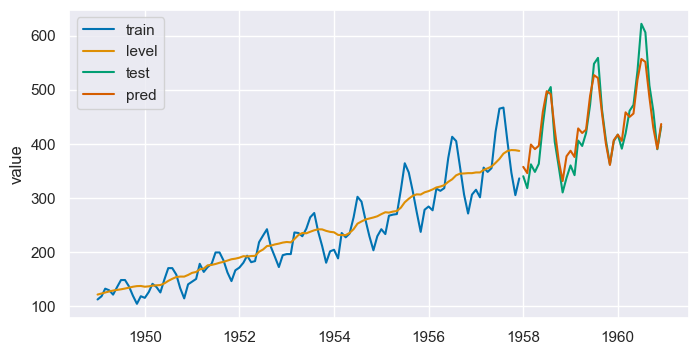

In [46]:
# ==========================================================
# Holt-Winters法による予測結果とトレンド（level）の可視化
# ==========================================================
# グラフ構成：
#   - train ：学習に用いた実測データ（青線）
#   - level ：指数平滑化で抽出された「水準成分」（オレンジ線）
#   - test  ：評価用データ（緑線）
#   - pred  ：予測値（赤線）
#
# この可視化により、
# Holt-Wintersモデルが季節性を補正しながら
# 全体のトレンドをどのように捉えているかを確認できる。
# ==========================================================

fig, ax = plot_series(
    train,  # 学習データ
    hw_air.level,  # モデルが抽出したトレンド成分（level）
    test,  # テストデータ
    pred,  # 予測結果
    labels=["train", "level", "test", "pred"],
    markers=np.tile("", 4),  # 点を非表示にして滑らかに描画
)

# グラフサイズを指定（横長で見やすく）
fig.set_size_inches(8, 4)

In [47]:
# ==========================================================
# Holt-Winters法（乗法型季節モデル）の構築と評価
# ==========================================================
# モデル構成：
#   - trend='add' ：トレンドは加法型（一定の増加・減少）
#   - seasonal='mul' ：季節成分は乗法型（値の大きさに比例して変動）
#   - seasonal_periods=12 ：12ヶ月を1周期とする月次データ
#
# このモデルは「季節変動の振幅が時間とともに大きくなる」場合に有効。
# （例：飛行機乗客数など、年々増加する季節パターンを持つデータ）
# ==========================================================

# モデル化（乗法型季節モデル）
hw_air_mul = tsa.ExponentialSmoothing(
    train, trend="add", seasonal="mul", seasonal_periods=12
).fit()

# 予測の実施（テストデータと同じ期間）
pred_mul = hw_air_mul.forecast(len(test))

# 予測精度の評価（平均絶対誤差）
mean_absolute_error(test, pred_mul)

22.62929469551634